# Causal Models and Synthetic Data for Microservice Root Cause Analysis

Microservice outages often result from cascading failures. An initial fault triggers high latency or errors in one service, which propagate through dependent services and amplify the problem. Identifying the root cause in such scenarios requires understanding the chain of causal events leading to the incident. 

Below, we present three causal models (small, medium and large scale) for root cause analysis in a microservice observability context, as well as corresponding code to generate synthetic data for the models.

In [6]:
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

### Model 1: Small-scale Outage Incident

In [25]:
model_1 = nx.DiGraph([('NewDeploy', 'MemLeak'),
                      ('MemLeak', 'MemUsageHigh'), 
                      ("MemUsageHigh", "ServiceCrash"), 
                      ("ServiceCrash", "Outage"),
                      ("HeavyTraffic", "MemUsageHigh"), 
                      ("HeavyTraffic", "ServiceCrash")])

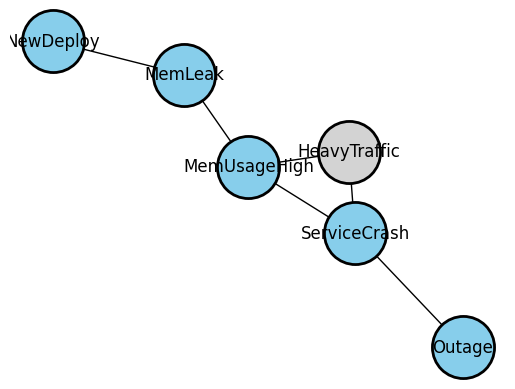

In [32]:
G = model_1

latent_nodes = {'HeavyTraffic'}
node_colors = ['lightgray' if node in latent_nodes else 'skyblue' for node in G.nodes()]
node_styles = ['dashed' if node in latent_nodes else 'solid' for node in G.nodes()]

pos = nx.spring_layout(G)

for node, style in zip(G.nodes(), node_styles):
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[node],
                           node_color='lightgray' if node in latent_nodes else 'skyblue',
                           node_size=2000,
                           edgecolors='black',
                           linewidths=2,
                           node_shape='o')
    if style == 'dashed':
        circle = plt.Circle(pos[node], 0.05, color='black', fill=False, linestyle='dashed')
        plt.gca().add_artist(circle)

nx.draw_networkx_edges(G, pos, arrows=True)

nx.draw_networkx_labels(G, pos, font_size=12)

plt.axis('off')
plt.show()

In [57]:
def generate_small_model_data(n_samples=1000, include_latent=False, seed=42):
    """Generate a synthetic dataset for the small-scale causal model.
    Returns a pandas DataFrame with n_samples rows following the DAG:
    NewDeploy -> MemoryLeak -> MemoryUsageHigh -> ServiceCrash -> OutageIncident,
    with a latent HeavyTraffic influencing MemoryUsageHigh and ServiceCrash.
    If include_latent is True, the latent HeavyTraffic column is included for reference."""
    
    rng = np.random.default_rng(seed) 

    # 10% of times a new deploy happens
    Deploy_NewVersion = rng.binomial(1, 0.1, size=n_samples)  
    
    # MemoryLeakBug: if a new version is deployed, there's a high chance it introduces a bug
    MemoryLeakBug = np.zeros(n_samples, dtype=int)
    # e.g., 90% chance the new deployment has the memory leak bug
    MemoryLeakBug[Deploy_NewVersion == 1] = rng.binomial(1, 0.9, size=np.sum(Deploy_NewVersion == 1))
    # If no new deployment, no new bug (could also include a small probability of bug without deployment if needed)
    
    # Latent heavy traffic surge (unobserved)
    HeavyTraffic = rng.binomial(1, 0.1, size=n_samples)  # 10% chance of a heavy traffic spike in a time window
    
    # MemoryUsageHigh: can be caused by MemoryLeakBug or HeavyTraffic (or both)
    MemoryUsageHigh = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        if MemoryLeakBug[i] == 1 and HeavyTraffic[i] == 1:
            # Both bug and heavy traffic -> very high chance of high memory usage
            MemoryUsageHigh[i] = rng.binomial(1, 0.95)
        elif MemoryLeakBug[i] == 1 and HeavyTraffic[i] == 0:
            # Bug alone -> high memory usage likely, but not guaranteed immediately
            MemoryUsageHigh[i] = rng.binomial(1, 0.8)
        elif MemoryLeakBug[i] == 0 and HeavyTraffic[i] == 1:
            # Heavy traffic alone -> can cause high memory usage due to load
            MemoryUsageHigh[i] = rng.binomial(1, 0.5)
        else:
            # Neither bug nor heavy traffic -> low baseline chance of high memory (e.g., other minor factors)
            MemoryUsageHigh[i] = rng.binomial(1, 0.05)
    
    # ServiceCrash: can be caused by MemoryUsageHigh or directly by HeavyTraffic (e.g., CPU overload crash)
    ServiceCrash = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        if MemoryUsageHigh[i] == 1:
            # If memory is high, there's a strong chance of crash
            ServiceCrash[i] = rng.binomial(1, 0.9)
        elif MemoryUsageHigh[i] == 0 and HeavyTraffic[i] == 1:
            # Even without high memory, heavy traffic might cause a crash due to other overload (e.g., CPU)
            ServiceCrash[i] = rng.binomial(1, 0.5)
        else:
            # No high memory and no heavy traffic -> very low chance of crash (random hardware failure, etc.)
            ServiceCrash[i] = rng.binomial(1, 0.01)
    
    # OutageIncident: we consider an outage if the service crashed (could also incorporate high error as criteria)
    OutageIncident = ServiceCrash.copy()  # Outage happens whenever there's a crash in this simple model
    
    data = {
        "NewDeploy": Deploy_NewVersion,
        "MemoryLeak": MemoryLeakBug,
        "MemoryUsageHigh": MemoryUsageHigh,
        "ServiceCrash": ServiceCrash,
        "OutageIncident": OutageIncident
    }
    if include_latent:
        data["HeavyTraffic"] = HeavyTraffic  # include latent for reference if needed
    df = pd.DataFrame(data)
    return df

In [58]:
df_small_scale_model = generate_small_model_data(n_samples=10000, include_latent=True)

In [59]:
df_small_scale_model.head(10)

,NewDeploy,MemoryLeak,MemoryUsageHigh,ServiceCrash,OutageIncident,HeavyTraffic
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,1,1,1
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,1,1,1,1,1,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [60]:
df_small_scale_model.to_csv("small_scale_outage_incident_seed42.csv")

### Model 2: Medium-scale Outage Incident

In [61]:
model_2 = nx.DiGraph([("DB_Change", "DB_Latency"),
                      ("DB_Latency", "MS-B_Latency"), 
                      ("MS-B_Latency", "MS-B_Error"), 
                      ("MS-B_Latency", "MS-A_Latency"),
                      ("MS-B_Error", "MS-A_Error"), 
                      ("MS-A_Latency", "MS-A_Threads"), 
                      ("MS-A_Threads", "MS-A_Crash"), 
                      ("MS-A_Error", "Outage"), 
                      ("MS-A_Crash", "Outage"), 
                      ("HeavyTraffic", "DB_Latency"), 
                      ("HeavyTraffic", "MS-A_Latency")])

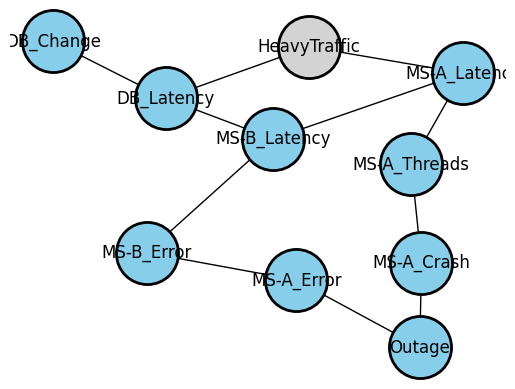

In [39]:
G = model_2

latent_nodes = {'HeavyTraffic'}

node_colors = ['lightgray' if node in latent_nodes else 'skyblue' for node in G.nodes()]
node_styles = ['dashed' if node in latent_nodes else 'solid' for node in G.nodes()]

pos = nx.spring_layout(G)

for node, style in zip(G.nodes(), node_styles):
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[node],
                           node_color='lightgray' if node in latent_nodes else 'skyblue',
                           node_size=2000,
                           edgecolors='black',
                           linewidths=2,
                           node_shape='o')
    if style == 'dashed':
        circle = plt.Circle(pos[node], 0.05, color='black', fill=False, linestyle='dashed')
        plt.gca().add_artist(circle)

nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=12)

plt.axis('off')
plt.show()

In [62]:
def generate_medium_model_data(n_samples=1000, include_latent=False, seed=42):
    """Generate a synthetic dataset for the medium-scale causal model.
    Returns a pandas DataFrame with n_samples rows following the DAG described:
    DB_Change -> DB_Latency -> MS-B_Latency -> {MS-B_Error, MS-A_Latency} -> ...
    MS-A_Latency -> MS-A_Threads -> MS-A_Crash -> Outage,
    MS-B_Error -> MS-A_Error -> Outage,
    with latent HeavyTraffic influencing DB_Latency and MS-A_Latency."""
    
    rng = np.random.default_rng(seed)
    
    # Upstream causes
    DB_ConfigChange = rng.binomial(1, 0.05, size=n_samples)  # 5% chance of a config change in a given window
    HeavyTraffic = rng.binomial(1, 0.1, size=n_samples)      # 10% chance of heavy traffic spike
    
    # Database latency high
    DB_LatencyHigh = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        # If config changed, increase probability of high latency
        if DB_ConfigChange[i] == 1 and HeavyTraffic[i] == 1:
            DB_LatencyHigh[i] = rng.binomial(1, 0.95)  # misconfig + heavy load -> almost certain high latency
        elif DB_ConfigChange[i] == 1 and HeavyTraffic[i] == 0:
            DB_LatencyHigh[i] = rng.binomial(1, 0.8)   # misconfig alone -> likely high latency
        elif DB_ConfigChange[i] == 0 and HeavyTraffic[i] == 1:
            DB_LatencyHigh[i] = rng.binomial(1, 0.7)   # heavy traffic alone -> can cause high DB latency
        else:
            DB_LatencyHigh[i] = rng.binomial(1, 0.1)   # neither -> low chance (baseline) 
    # (The baseline 10% could represent other minor issues causing occasional latency spikes.)
    
    # Service B latency high (depends on DB latency and heavy load)
    ServiceB_LatencyHigh = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        if DB_LatencyHigh[i] == 1 or HeavyTraffic[i] == 1:
            # If DB is slow or there's heavy load (more requests to B), B likely has high latency
            # If both conditions, increase probability further
            p = 0.9 if (DB_LatencyHigh[i] == 1 and HeavyTraffic[i] == 1) else 0.75
            ServiceB_LatencyHigh[i] = rng.binomial(1, p)
        else:
            ServiceB_LatencyHigh[i] = rng.binomial(1, 0.05)  # otherwise low chance of high latency
    # Note: HeavyTraffic contributes to B latency largely via DB and A in reality, but we include it here as an independent factor for completeness.
    
    # Service B error rate high (caused by B latency high)
    ServiceB_ErrorHigh = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        if ServiceB_LatencyHigh[i] == 1:
            # If B latency is high, some requests will fail/time out -> errors
            ServiceB_ErrorHigh[i] = rng.binomial(1, 0.6)
        else:
            ServiceB_ErrorHigh[i] = rng.binomial(1, 0.02)  # baseline error rate
    
    # Service A latency high (caused by B latency and heavy load)
    ServiceA_LatencyHigh = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        # If Service B is slow or heavy traffic directly hitting A, A latency can be high
        if ServiceB_LatencyHigh[i] == 1 or HeavyTraffic[i] == 1:
            p = 0.85 if (ServiceB_LatencyHigh[i] == 1 and HeavyTraffic[i] == 1) else 0.6
            ServiceA_LatencyHigh[i] = rng.binomial(1, p)
        else:
            ServiceA_LatencyHigh[i] = rng.binomial(1, 0.05)
    
    # Service A error rate high (caused by B errors primarily)
    ServiceA_ErrorHigh = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        if ServiceB_ErrorHigh[i] == 1:
            # If B failed calls, A likely returns errors for those parts of the request
            ServiceA_ErrorHigh[i] = rng.binomial(1, 0.8)
        elif ServiceA_LatencyHigh[i] == 1:
            # If A is very slow (even if B isn't erroring), some requests might time out at A's end
            ServiceA_ErrorHigh[i] = rng.binomial(1, 0.3)
        else:
            ServiceA_ErrorHigh[i] = rng.binomial(1, 0.01)  # baseline
    
    # Service A threads exhausted (caused by A latency high)
    ServiceA_ThreadsExhausted = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        if ServiceA_LatencyHigh[i] == 1:
            ServiceA_ThreadsExhausted[i] = rng.binomial(1, 0.7)
        else:
            ServiceA_ThreadsExhausted[i] = rng.binomial(1, 0.05)
    
    # Service A crash (caused by threads exhausted)
    ServiceA_Crash = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        if ServiceA_ThreadsExhausted[i] == 1:
            ServiceA_Crash[i] = rng.binomial(1, 0.8)
        else:
            ServiceA_Crash[i] = rng.binomial(1, 0.01)
    
    # Incident: occurs if either A crashed or A had high errors (user impact)
    Incident = np.zeros(n_samples, dtype=int)
    for i in range(n_samples):
        if ServiceA_Crash[i] == 1 or ServiceA_ErrorHigh[i] == 1:
            Incident[i] = 1
        else:
            Incident[i] = 0
    
    data = {
        "DB_Change": DB_ConfigChange,
        "DB_Latency": DB_LatencyHigh,
        "MS-B_Latency": ServiceB_LatencyHigh,
        "MS-B_Error": ServiceB_ErrorHigh,
        "MS-A_Latency": ServiceA_LatencyHigh,
        "MS-A_Error": ServiceA_ErrorHigh,
        "MS-A_Threads": ServiceA_ThreadsExhausted,
        "MS-A_Crash": ServiceA_Crash,
        "Outage": Incident
    }
    if include_latent:
        data["HeavyTraffic"] = HeavyTraffic
    df = pd.DataFrame(data)
    return df

In [63]:
df_medium_scale_model = generate_medium_model_data(n_samples=10000, include_latent=True)

In [64]:
df_medium_scale_model.head(10)

,DB_Change,DB_Latency,MS-B_Latency,MS-B_Error,MS-A_Latency,MS-A_Error,MS-A_Threads,MS-A_Crash,Outage,HeavyTraffic
0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,1,0
2,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,1,1,1,0,1,1,1,0,1,0
6,0,0,0,0,0,0,0,0,0,0
7,0,1,1,1,1,1,1,1,1,1
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


In [65]:
df_medium_scale_model.to_csv("medium_scale_outage_incident_seed42.csv")

### Model 3: Large-scale Outage Incident